In [1]:
!pip install -e "git+https://github.com/AnjuBhat247/Optimizing-Clustering-Metrics-for-Patient-Stratification#egg=ClusteringAlgorithms"

Obtaining ClusteringAlgorithms from git+https://github.com/AnjuBhat247/Optimizing-Clustering-Metrics-for-Patient-Stratification#egg=ClusteringAlgorithms
  Cloning https://github.com/AnjuBhat247/Optimizing-Clustering-Metrics-for-Patient-Stratification to ./src/clusteringalgorithms
  Running command git clone --filter=blob:none --quiet https://github.com/AnjuBhat247/Optimizing-Clustering-Metrics-for-Patient-Stratification /content/src/clusteringalgorithms
  Resolved https://github.com/AnjuBhat247/Optimizing-Clustering-Metrics-for-Patient-Stratification to commit ac5337d1ed18d130d20d6a7b669ada844826dc76
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 550.6/550.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 39.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.9 MB

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/src')

In [3]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from scipy.stats import mode
import matplotlib.pyplot as plt
import time
import contextlib
import io
import snf
from sklearn.cluster import KMeans,SpectralClustering

from clusteringalgorithms.package import genetic_algorithm, random_search

In [4]:
clinical_data = pd.read_csv('/content/drive/MyDrive/data/clinical_data_all.csv')
clinical_data.dtypes

Study ID                          object
Patient ID                        object
Sample ID                         object
Diagnosis Age                    float64
Cancer Type                       object
Cancer Type Detailed              object
Disease Free (Months)            float64
Disease Free Status               object
Gene Expression Subtype           object
Fraction Genome Altered          float64
G-CIMP  Methylation               object
IDH1 Mutation                     object
Methylation Status                object
MGMT Status                       object
Mutation Count                   float64
Oncotree Code                     object
Overall Survival (Months)        float64
Overall Survival Status           object
Number of Samples Per Patient      int64
Sample Type                       object
Sex                               object
Somatic Status                    object
therapy                           object
TMB (nonsynonymous)              float64
dtype: object

In [5]:
clinical_GBM = pd.read_csv('/content/drive/MyDrive/data/clinical_GBM.csv')
clinical_GBM.dtypes, clinical_GBM['status'].value_counts()

(Patient ID     object
 Time          float64
 status          int64
 dtype: object,
 status
 1    417
 0    124
 Name: count, dtype: int64)

Text(0.5, 1.0, 'GBM')

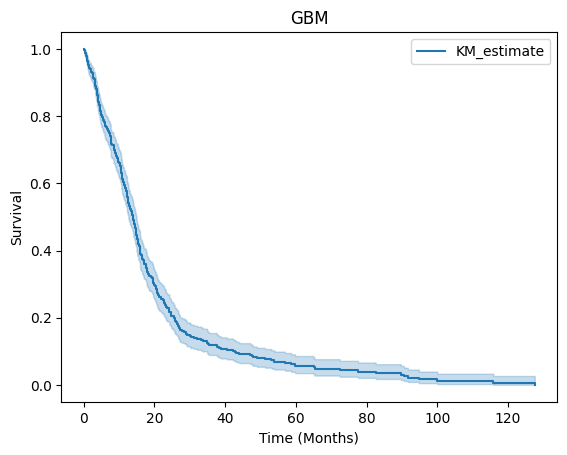

In [6]:
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=clinical_GBM['Time'],event_observed=clinical_GBM['status'])
plt.figure()
kmf1.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival')
plt.title('GBM')

In [42]:
data_rna = pd.read_csv('/content/drive/MyDrive/data/GBM_RNA_data.csv').T
data_rna.index = data_rna.index.str.split('-', n=3).str[:3].str.join('-')
data_rna = data_rna[data_rna.index.isin(clinical_GBM['Patient ID'])].drop_duplicates()
data_rna

,0,1,2,3,4,5,6,7,8,9,...,60650,60651,60652,60653,60654,60655,60656,60657,60658,60659
TCGA-27-2521,5.8836,1.3023,115.9459,6.9493,4.3589,6.8639,2.4921,30.7555,17.7058,19.6703,...,0.0,0.0,0.4021,0.0,0.000,0.0,9.9826,0.0,0.0154,1.4962
TCGA-19-1390,21.6593,0.0472,58.7679,6.2764,6.9562,19.6550,3.5974,27.9751,20.4718,61.4327,...,0.0,0.0,1.1248,0.0,0.000,0.0,14.1517,0.0,0.0145,2.9447
TCGA-27-1830,70.7455,0.5954,73.9292,6.2558,3.7066,13.5112,11.2121,66.7509,19.0028,20.8152,...,0.0,0.0,0.8551,0.0,0.000,0.0,12.8649,0.0,0.1163,1.7118
TCGA-32-1970,60.4303,0.8658,52.6728,5.6279,4.0002,11.5010,16.3642,45.8216,23.7532,26.9724,...,0.0,0.0,0.8128,0.0,0.000,0.0,12.9506,0.0,0.0415,4.3738
TCGA-06-0190,70.0066,0.2893,80.6678,4.8642,6.9529,25.5317,24.9163,101.1771,17.4425,28.6862,...,0.0,0.0,0.4046,0.0,0.000,0.0,6.0973,0.0,0.0178,3.0503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-0184,90.9708,0.4192,67.9240,4.0992,2.8605,23.1985,5.6137,45.6936,13.0025,13.8005,...,0.0,0.0,0.3366,0.0,0.000,0.0,5.9581,0.0,0.0515,1.5100
TCGA-32-2638,106.4214,1.6188,93.3104,6.1924,3.9699,11.1514,8.1897,52.9309,10.3635,21.9951,...,0.0,0.0,0.9405,0.0,0.000,0.0,12.1867,0.0,0.0671,2.5755
TCGA-12-3652,122.5849,0.3432,119.4728,3.4468,5.1336,5.1676,2.4863,70.0678,11.1193,12.7163,...,0.0,0.0,0.1185,0.0,0.000,0.0,3.0837,0.0,0.0263,1.3066
TCGA-28-5209,82.1417,0.5437,83.4400,6.7389,6.4656,7.2134,27.8558,46.0961,15.3365,28.7851,...,0.0,0.0,0.2394,0.0,0.000,0.0,9.9922,0.0,0.0501,2.6272


In [44]:
# data_rna.index[data_rna.index.duplicated()]
data_rna = data_rna[~data_rna.index.duplicated(keep='first')]

In [12]:
GBM_df = clinical_GBM[clinical_GBM['Patient ID'].isin(data_rna.index)].reset_index(drop=True)
GBM_df

,Patient ID,Time,status
0,TCGA-02-0047,14.7,1
1,TCGA-02-0055,2.5,1
2,TCGA-02-2483,15.3,0
3,TCGA-02-2485,15.4,0
4,TCGA-02-2486,16.2,0
...,...,...,...
155,TCGA-76-4927,17.6,1
156,TCGA-76-4928,3.1,1
157,TCGA-76-4929,3.7,1
158,TCGA-76-4931,9.1,1


Text(0.5, 1.0, 'GBM')

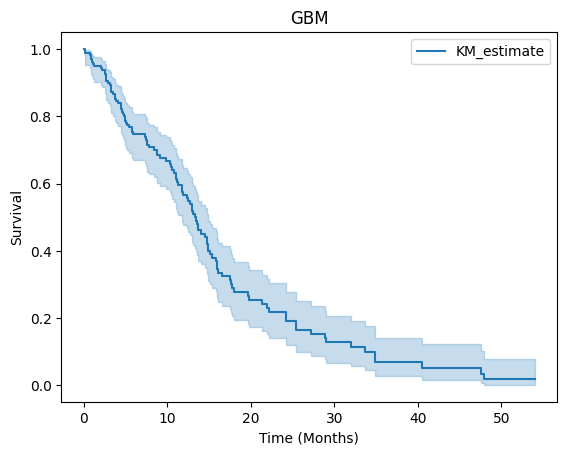

In [10]:
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=GBM_df['Time'],event_observed=GBM_df['status'])

plt.figure()
kmf1.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival')
plt.title('GBM')

In [11]:
GBM_df['status'].value_counts()

status
1    107
0     53
Name: count, dtype: int64

In [63]:
ga = genetic_algorithm.GeneticAlgorithm(GBM_df['Time'], GBM_df['status'],res='best_dist',nres=100)
best_solution, best_fitness = ga.run()
# print("Best solution:", best_solution)
# print("Best fitness (log-rank p-value):", best_fitness)

0
0.0009261758871095458
1
0.0003964514016866275
2
0.0005331737121940121
3
7.596038545735328e-05
4
0.00012682059696540488
5
0.0005249256490882571
6
0.00013628878039389277
7
6.064264473763917e-05
8
7.336027603176102e-07
9
1.7189551089692367e-06
10
7.975500222379677e-07
11
2.453181783814849e-07
12
9.323098627767524e-08
13
5.741863742576541e-09
14
3.201410275534554e-09
15
2.142758815913186e-09
16
2.250351980998266e-09
17
3.136909227844164e-10
18
1.1937535325172701e-10
19
5.808636233558942e-12
20
5.808636233558942e-12
21
4.068033509201171e-12
22
2.0422141429491932e-12
23
4.068033509201171e-12
24
1.5238151025077648e-13
25
1.6159690391439692e-13
26
1.6159690391439692e-13
27
8.018974415191289e-15
28
7.429090161853919e-15
29
6.2881513670153345e-15
30
6.2881513670153345e-15
31
6.391407584253856e-16
32
5.0815108570231485e-17
33
8.705523539262002e-18
34
2.9215901600588523e-17
35
3.117987813858426e-17
36
3.031140943248218e-17
37
2.0564696285172405e-17
38
1.0161626534675079e-17
Total time taken :  5

In [64]:
def kmf_plot(best_sol):
  labels_final = pd.DataFrame({'label': best_sol})
  unique_clusters = labels_final['label'].unique()

  kmf = {}
  for cluster in unique_clusters:
      kmf[cluster] = KaplanMeierFitter()

  plt.figure()

  for cluster in unique_clusters:
      cluster_data = GBM_df.iloc[labels_final.index[labels_final['label'] == cluster].tolist()]
      kmf[cluster].fit(durations=cluster_data['Time'], event_observed=cluster_data['status'], label=f'Cluster {cluster}')
      kmf[cluster].plot()

  # Perform multivariate log-rank test
  logrank_test = multivariate_logrank_test(event_durations=GBM_df['Time'], groups=best_sol, event_observed=GBM_df['status'])
  p_val = logrank_test.p_value
  t_stat = logrank_test.test_statistic

  # Plot details
  plt.xlabel('Time (Months)')
  plt.ylabel('Survival')
  plt.text(0.4, 0.5, f'p-value: {p_val:}\nt-statistic: {t_stat:.2f}', transform=plt.gca().transAxes)

  # Show plot
  plt.show()

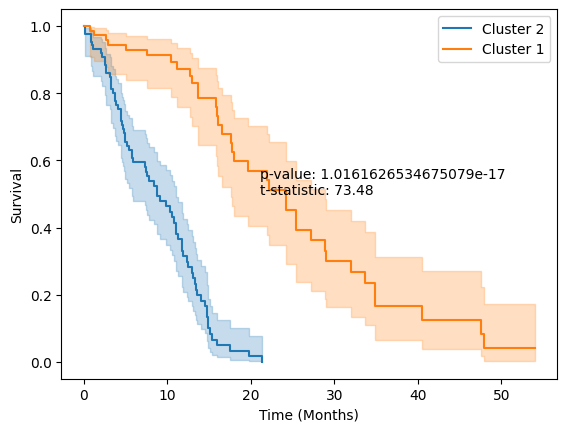

In [65]:
best_sol = best_solution[best_fitness.index(min(best_fitness))]
kmf_plot(best_sol)

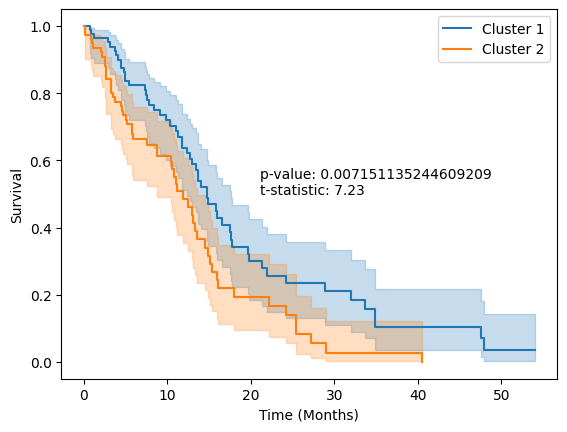

In [20]:
np.random.seed(0)
scores, best_solution = random_search.Random_Search(GBM_df['Time'], GBM_df['status'],num_clusters=2)
kmf_plot(best_solution)

In [76]:
## Obtaining SNF network of GEX omic
# affinity_networks = snf.make_affinity(data_rna.values, metric='euclidean', K=30, mu=0.3)
# fused_network = snf.snf(affinity_networks, K=30)
# best, second = snf.get_n_clusters(fused_network)
# best,second

KMeans and spectral clustering for GEX

In [77]:
## Applying KMeans 100 times
sol_km, sol_sc = [], []
scores_km, scores_sc = [], []
for i in range(100):
  km = KMeans(n_clusters=2,init='random',n_init=10)
  sc = SpectralClustering(n_clusters=2,affinity='nearest_neighbors')
  pred_km = km.fit_predict(data_rna.values)
  pred_sc = sc.fit_predict(data_rna.values)
  sol_km.append(pred_km)
  scores_km.append(multivariate_logrank_test(event_durations=GBM_df['Time'], groups=pred_km, event_observed=GBM_df['status']).p_value)
  sol_sc.append(pred_sc)
  scores_sc.append(multivariate_logrank_test(event_durations=GBM_df['Time'], groups=pred_sc, event_observed=GBM_df['status']).p_value)

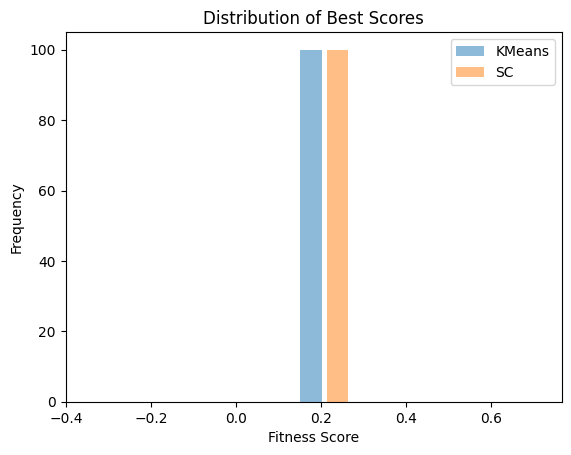

In [78]:
plt.figure()
plt.hist(-np.log10(scores_km), bins=20, alpha=0.5, label='KMeans')
plt.hist(-np.log10(scores_sc), bins=20, alpha=0.5, label='SC')
plt.xlabel('Fitness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Best Scores')
plt.legend(loc='upper right')
plt.show()
### all scores are same

Considering clinical data features

In [79]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
data_encoded = encoder.fit_transform(clinical_data[['Sex', 'Cancer Type']])
df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(['Sex', 'Cancer Type']))
df_numeric = pd.DataFrame(clinical_data['Diagnosis Age'], columns=['Diagnosis Age'])
df_merged = pd.concat([df_encoded, df_numeric], axis=1)

sol_km2, sol_sc2 = [], []
scores_km2, scores_sc2 = [], []
for i in range(100):
  km = KMeans(n_clusters=2,init='random',n_init=10)
  sc = SpectralClustering(n_clusters=2,affinity='nearest_neighbors')
  pred_km = km.fit_predict(df_merged.values)
  pred_sc = sc.fit_predict(df_merged.values)
  sol_km2.append(pred_km)
  scores_km2.append(multivariate_logrank_test(event_durations=GBM_df['Time'], groups=pred_km, event_observed=GBM_df['status']).p_value)
  sol_sc2.append(pred_sc)
  scores_sc2.append(multivariate_logrank_test(event_durations=GBM_df['Time'], groups=pred_sc, event_observed=GBM_df['status']).p_value)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


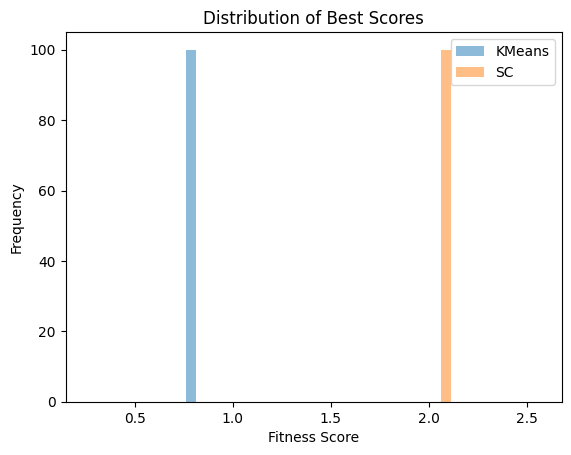

In [80]:
plt.figure()
plt.hist(-np.log10(scores_km2), bins=20, alpha=0.5, label='KMeans')
plt.hist(-np.log10(scores_sc2), bins=20, alpha=0.5, label='SC')
plt.xlabel('Fitness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Best Scores')
plt.legend(loc='upper right')
plt.show()

In [81]:
scores_sc

[0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469709685,
 0.6110474469

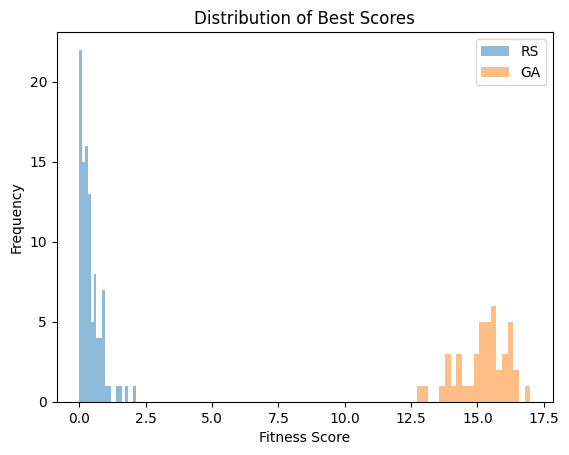

In [66]:
# Plot histograms
plt.figure()
plt.hist(-np.log10(scores), bins=20, alpha=0.5, label='RS')
plt.hist(-np.log10(best_fitness), bins=20, alpha=0.5, label='GA')
plt.xlabel('Fitness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Best Scores')
plt.legend(loc='upper right')
plt.show()
